## Import libs

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Sweetviz for EDA
import sweetviz as sv

# Preprocessing and pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder, 
                                   OneHotEncoder, StandardScaler)

# Model and model selection
from flaml import AutoML
from sklearn.ensemble import RandomForestClassifier

# Under sampling
from imblearn.under_sampling import RandomUnderSampler

# Metrics and evaluation
from sklearn.metrics import (auc, classification_report, confusion_matrix, 
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.metrics._plot.roc_curve import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Multithreading
import multiprocessing as mp

# Pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
import pkg_resources

# List of libraries you want to check
libraries = ["warnings", "pandas", "numpy", "sweetviz", "sklearn", 
             "flaml", "imblearn", "xgboost", 'matplotlib', 'seaborn', 'multiprocessing']

# Print the library names and their versions
for lib in libraries:
    try:
        version = pkg_resources.get_distribution(lib).version
        print(f"- **{lib}** (version {version})")
    except pkg_resources.DistributionNotFound:
        print(f"- **{lib}** (not installed)")


---
# Part 1: Testing RF


#### Read in data:

In [3]:
transactions = "credit_card_transaction_data_de.parquet"
trans_df = pd.read_parquet(transactions)

In [ ]:
import sweetviz as sv

#analyzing the dataset
eda_report = sv.analyze(trans_df)
#display the report
eda_report.show_notebook()

#### Perform data manipulation and model building

In [4]:
# "Is Fraud?" column is Boolean - convert it to float (0=No, 1=Yes)
trans_df['Is Fraud?'] = trans_df['Is Fraud?'].replace({'No': 0, 'Yes': 1})

# "Amount" column ==> replace "$" with "" ==> convert to float
trans_df["Amount"] = trans_df["Amount"].str.replace("$", "").astype(float)

# Assign ordinal values to "Use Chip"
trans_df['Use Chip'] = trans_df['Use Chip'].replace({'Swipe Transaction': 0, 'Online Transaction': 1, 'Chip Transaction': 2})

# "Errors?" 0=NaN, 1=otherwise
trans_df['Errors?'] = trans_df['Errors?'].fillna('NaN')
trans_df['Errors?'] = trans_df['Errors?'].apply(lambda value: value != 'NaN')
trans_df['Errors?'] = trans_df['Errors?'].replace({'False': 0, 'True': 1}).astype(float)

# "Time" we can extract particular components such as: hour and minute
trans_df['Hour'] = trans_df['Time'].apply(lambda value: int(value.split(":")[0]))
trans_df['Minutes'] = trans_df['Time'].apply(lambda value: int(value.split(":")[1]))

# Normalize 'Merchant State' & 'Merchant City' columns
if 'Merchant State' in trans_df.columns and 'Merchant City' in trans_df.columns:
    trans_df['Merchant State'] = trans_df['Merchant State'].str.lower().str.strip()
    trans_df['Merchant City'] = trans_df['Merchant City'].str.lower().str.strip()
else:
    print("Columns 'Merchant State' or 'Merchant City' are not found in DataFrame")

# Drop 'Time' column
trans_df.drop(['Time'], axis=1, inplace=True)

# Select relevant columns
columns_to_select = ['Month', 'Day', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Errors?', 'Is Fraud?', 'Hour', 'Minutes']
trans_df2 = trans_df[columns_to_select]


# Split the dataset into features (X) and target variable (y)
X = trans_df2.drop(columns=['Is Fraud?'])
y = trans_df2['Is Fraud?']

# Under-sampling
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

# Model training with RF
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluation
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9608
           1       0.90      0.80      0.85      2392

    accuracy                           0.94     12000
   macro avg       0.93      0.89      0.91     12000
weighted avg       0.94      0.94      0.94     12000



---
# Part 2: using XGBoost

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Preprocessing and pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder, 
                                   OneHotEncoder, StandardScaler)

# Model and model selection
from flaml import AutoML
from sklearn.ensemble import RandomForestClassifier

# Under sampling
from imblearn.under_sampling import RandomUnderSampler

# Metrics and evaluation
from sklearn.metrics import (auc, classification_report, confusion_matrix, 
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.metrics._plot.roc_curve import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Multithreading
import multiprocessing as mp

# Pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
transactions = "credit_card_transaction_data_de.parquet"
trans_df = pd.read_parquet(transactions)

[flaml.automl.logger: 11-13 21:40:08] {1679} INFO - task = classification
[flaml.automl.logger: 11-13 21:40:08] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 11-13 21:40:08] {1788} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl.logger: 11-13 21:40:08] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 11-13 21:40:08] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 11-13 21:40:09] {2344} INFO - Estimated sufficient time budget=2948s. Estimated necessary time budget=3s.
[flaml.automl.logger: 11-13 21:40:09] {2391} INFO -  at 0.3s,	estimator xgboost's best error=0.5556,	best estimator xgboost's best error=0.5556
[flaml.automl.logger: 11-13 21:40:09] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-13 21:40:09] {2391} INFO -  at 0.6s,	estimator xgboost's best error=0.5556,	best estimator xgboost's best error=0.5556
[flaml.automl.logger: 11-13 21:40:09] {2218} INFO - iteration 2, curren

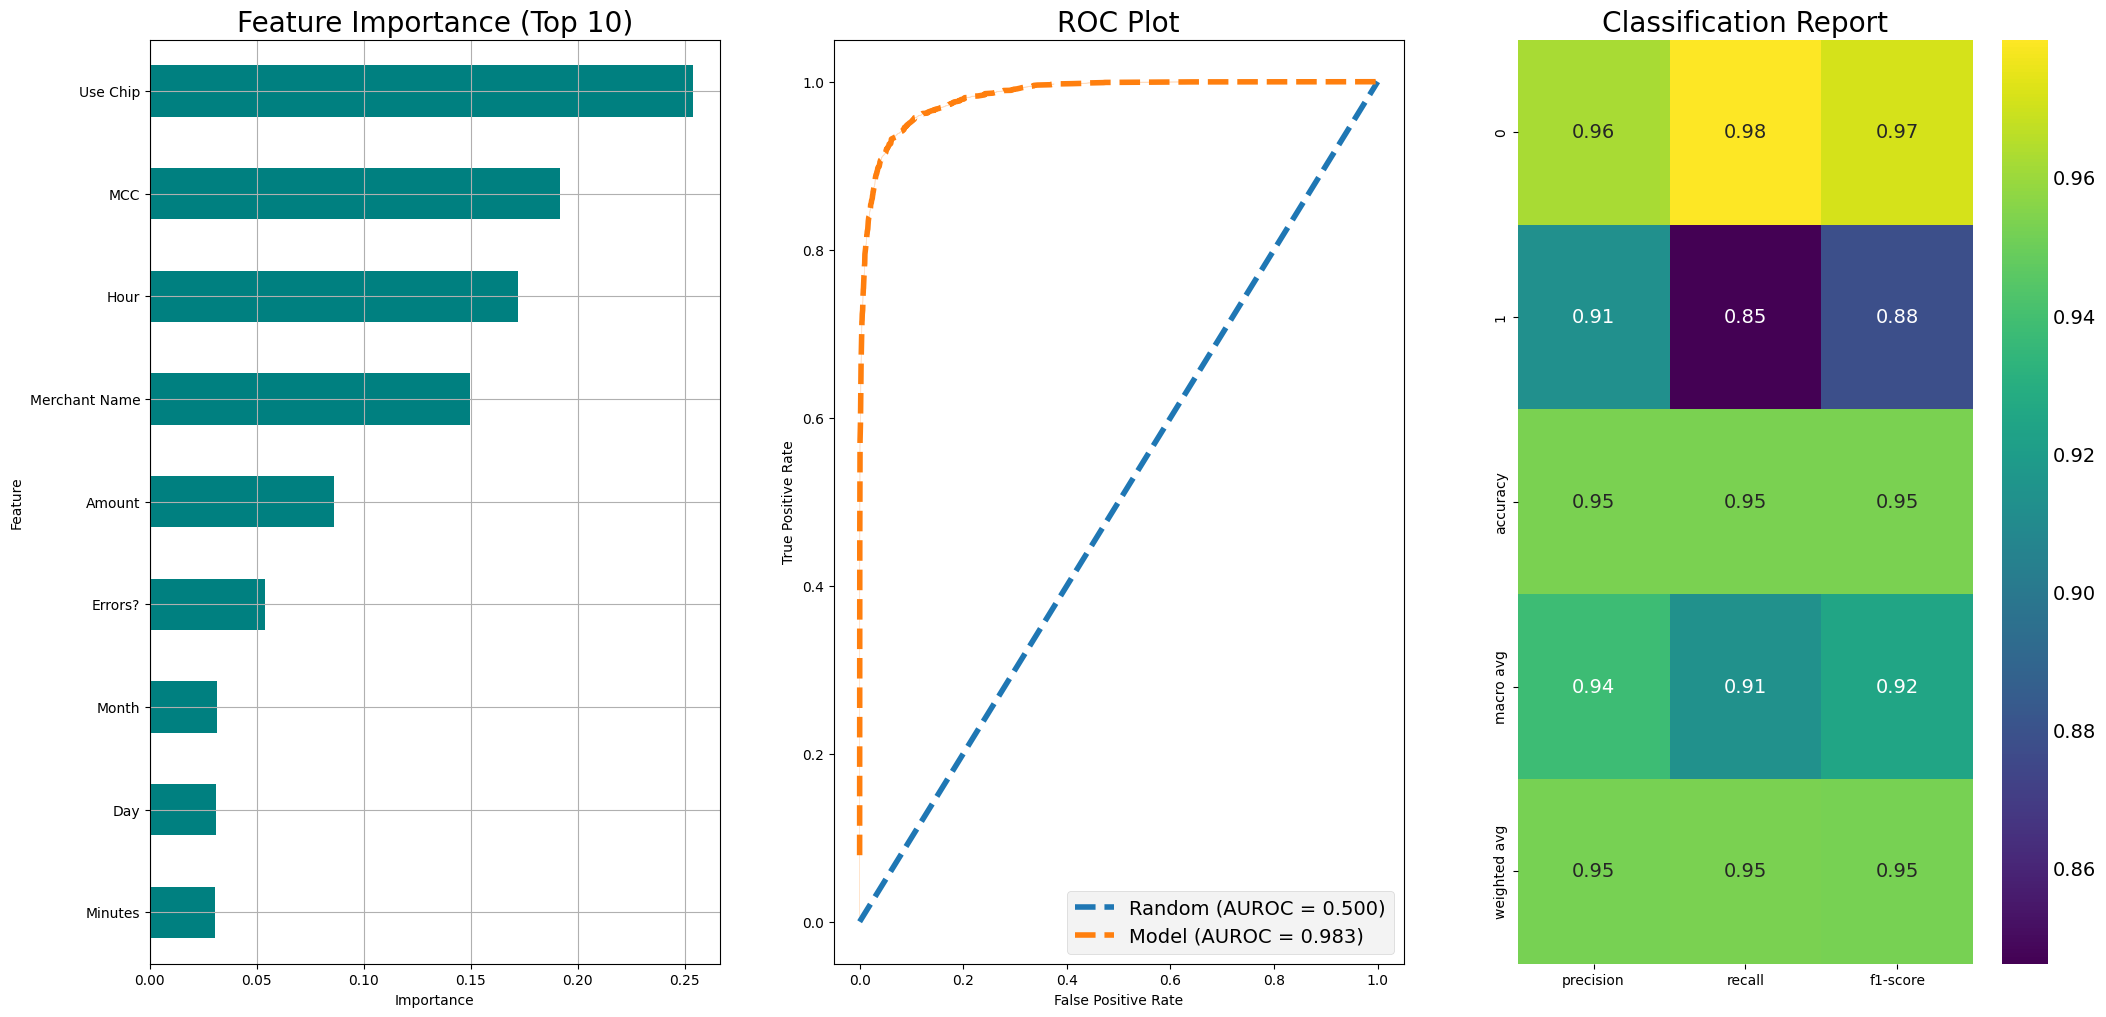

In [3]:
def preprocess_data(df, is_training_data=True):
    # Process 'Is Fraud?' only if it's present and the data is for training
    if is_training_data and 'Is Fraud?' in df.columns:
        df['Is Fraud?'] = df['Is Fraud?'].replace({'No': 0, 'Yes': 1})

    # Convert "Amount" column to float
    df["Amount"] = df["Amount"].astype(str).str.replace("$", "").astype(float)

    # Assign ordinal values to "Use Chip"
    df['Use Chip'] = df['Use Chip'].replace({'Swipe Transaction': 0, 'Online Transaction': 1, 'Chip Transaction': 2})

    # Process 'Errors?' column
    df['Errors?'] = df['Errors?'].fillna('NaN')
    df['Errors?'] = df['Errors?'].apply(lambda value: value != 'NaN')
    df['Errors?'] = df['Errors?'].replace({'False': 0, 'True': 1}).astype(float)

    # Check and process 'Time' column only if it exists
    if 'Time' in df.columns:
        df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
        df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
        df.drop(['Time'], axis=1, inplace=True)
    
    # Normalize 'Merchant State' & 'Merchant City' columns
    if 'Merchant State' in df.columns and 'Merchant City' in df.columns:
        df['Merchant State'] = df['Merchant State'].str.lower().str.strip()
        df['Merchant City'] = df['Merchant City'].str.lower().str.strip()

    return df


def evaluate_and_plot_metrics(X_test, y_test, y_pred, y_proba, model, feature_names):
    fig, axs = plt.subplots(ncols=3, figsize=(25, 12))
    plt.style.use("fivethirtyeight")

    # Feature Importance Plot
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        gbc_coeff = pd.Series(feature_importance, feature_names).sort_values(ascending=False)[:10]
        gbc_coeff.sort_values().plot.barh(color='teal', ax=axs[0])
        axs[0].set_title('Feature Importance (Top 10)')
        axs[0].set_xlabel('Importance')
        axs[0].set_ylabel('Feature')
    else:
        axs[0].text(0.5, 0.5, "Model does not support feature importances.", ha='center', va='center', fontsize=14)

    # ROC Curve Plot
    r_probs = [0 for _ in range(len(y_test))]
    r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
    gbc_fpr, gbc_tpr, _ = roc_curve(y_test, y_proba)
    r_auc = roc_auc_score(y_test, r_probs)
    gbc_auc = roc_auc_score(y_test, y_proba)
    sns.lineplot(x=r_fpr, y=r_tpr, linestyle='--', label='Random (AUROC = %0.3f)' % r_auc, ax=axs[1])
    sns.lineplot(x=gbc_fpr, y=gbc_tpr, linestyle='--', label='Model (AUROC = %0.3f)' % gbc_auc, ax=axs[1])
    axs[1].set_title('ROC Plot')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')

    # Classification Report Heatmap
    clf_report = classification_report(y_test, y_pred, target_names=["0", "1"], output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='viridis', ax=axs[2])
    axs[2].set_title('Classification Report')

    plt.show()


# Apply preprocessing
trans_df = preprocess_data(trans_df)  

# Select relevant columns
columns_to_select = ['Month', 'Day', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Errors?', 'Is Fraud?', 'Hour', 'Minutes']
trans_df2 = trans_df[columns_to_select]
feature_names = trans_df2.drop(columns=['Is Fraud?']).columns.tolist()

# Split the dataset into features (X) and target variable (y)
X = trans_df2.drop(columns=['Is Fraud?'])
y = trans_df2['Is Fraud?']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Under-sampling
# using 0.2 as a representative sample of the minority and majority population
desired_proportion = 0.2
total_samples = 40000
fraud_samples = int(total_samples * desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

# Initialize AutoML from FLAML
automl = AutoML()

settings = {
    "time_budget": 1800,  
    "metric": 'macro_f1',  
    "estimator_list": ['xgboost'],  
    "task": 'classification',  
    "log_file_name": 'xgb.log',  
    "seed": 42,  
    "n_jobs": 11  
}

# Run AutoML search
automl.fit(X_train=X_train, y_train=y_train, **settings)

# Evaluate best pipeline
y_pred = automl.predict(X_test)
y_proba = automl.predict_proba(X_test)[:, 1]

print("AutoML (FLAML) best model results:")
evaluate_and_plot_metrics(X_test, y_test, y_pred, y_proba, automl, feature_names)

In [ ]:
evaluate_and_plot_metrics(X_test, y_test, y_pred, y_proba, automl, feature_names)

---
---

## Below predicts Fraud probability for a single observation

In [ ]:
def predict_fraud_probability(feature_values, scaler, model):
    """
    Predict the probability of fraud for a given transaction.

    :param feature_values: List of feature values in the order ['Month', 'Day', 'Amount', 'Use Chip', 
                        'Merchant Name', 'MCC', 'Errors?', 'Hour', 'Minutes']
    :param scaler: The StandardScaler object used for scaling the training data.
    :param model: The trained AutoML model.
    :return: Probability of the transaction being fraudulent.
    """

    # Creating a DataFrame from the input features
    columns = ['Month', 'Day', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Errors?', 'Hour', 'Minutes']
    input_df = pd.DataFrame([feature_values], columns=columns)

    # Preprocess the input DataFrame for prediction
    input_df_processed = preprocess_data(input_df, is_training_data=False)

    # Scale the features
    input_features = scaler.transform(input_df_processed)

    # Predict the probability of fraud
    fraud_probability = model.predict_proba(input_features)[:, 1]

    return fraud_probability[0]

# Example:
feature_values = [9.0, 1.0, 38.48, 0.0, -7.27612092139916e+17, 5411.0, 1.0, 6.0, 42.0]
fraud_probability = predict_fraud_probability(feature_values, scaler, automl)
print(f"Fraud Probability: {fraud_probability}")

---
## Predict fraud for a data frame


In [ ]:
def predict_fraud_probability_df(input_df, scaler, model):
    """
    Predicts the probability of fraud for each transaction in the input DataFrame.

    :param input_df: DataFrame with transaction data, columns in order 
                     ['Month', 'Day', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Errors?', 'Hour', 'Minutes']
    :param scaler: The StandardScaler object used for scaling the training data.
    :param model: The trained AutoML model.
    :return: Series of probabilities of the transactions being fraudulent.
    """

    # Preprocess the input DataFrame for prediction
    input_df_processed = preprocess_data(input_df, is_training_data=False)

    # Scale the features
    input_features = scaler.transform(input_df_processed)

    # Predict the probability of fraud for each row
    fraud_probabilities = model.predict_proba(input_features)[:, 1]

    return fraud_probabilities

## Testing on 5 years of data: `2010 < Years < 2016`

## `a) Fraud`

In [ ]:
df = pd.read_csv('credit_card_transactions-ibm_v2.csv')

filtered_df = df[(df['Year'] < 2016) & (df['Year'] > 2010)]
# filtered_df['Year'].value_counts()
filtered_df = preprocess_data(filtered_df)


filtered_df = filtered_df[['Month',
 'Day',
 'Amount',
 'Use Chip',
 'Merchant Name',
 'MCC',
 'Errors?',
 'Hour',
 'Minutes',
 'Is Fraud?']]

fraud_filtered = filtered_df[filtered_df['Is Fraud?'] == 1]
fraud_filtered = fraud_filtered.drop(['Is Fraud?'], axis=1)
print(fraud_filtered.shape)

In [ ]:
# filtered_df = preprocess_data(filtered_df)
fraud_filtered.head()

In [ ]:
fraud_probabilities = predict_fraud_probability_df(fraud_filtered, scaler, automl)
print("Fraud Probabilities:\n", fraud_probabilities)

In [ ]:
# Assuming fraud_probabilities is a list or array of fraud probabilities
count_greater_than_50 = sum(p > 0.50 for p in fraud_probabilities)
print(f"Number of transactions with fraud probability > 0.50: {count_greater_than_50}")

In [ ]:
5925/7739 # * 2011 - 2015 = ~77% for FRAUD (5 years)    df[(df['Year'] < 2016) & (df['Year'] > 2010)]

In [ ]:
plt.hist(fraud_probabilities, bins=10, edgecolor='black', alpha=0.7, color='teal')
plt.title('Fraud Probabilities (77% Captured)', fontsize=16)
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## `b) Not-Fraud`

In [ ]:
not_fraud_filtered = filtered_df[filtered_df['Is Fraud?'] == 0]
not_fraud_filtered = not_fraud_filtered.drop(['Is Fraud?'], axis=1)[:500000]
print(not_fraud_filtered.shape)

In [ ]:
not_fraud_probabilities = predict_fraud_probability_df(not_fraud_filtered, scaler, automl)
print("Fraud Probabilities:\n", not_fraud_probabilities)
count_greater_than_50 = sum(p < 0.50 for p in not_fraud_probabilities)
print(f"Number of transactions with not-fraud probability < 0.50: {count_greater_than_50}")

In [ ]:
486052/500000 # * covers 97%

In [ ]:
plt.hist(not_fraud_probabilities, bins=10, edgecolor='black', alpha=0.7, color='salmon')
plt.title('Not-Fraud Probabilities (97% Captured)', fontsize=16)
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

---
---
#### `RandomForest: using AutoML`: XGBoost above performs better (ignore below)

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Preprocessing and pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder, 
                                   OneHotEncoder, StandardScaler)

# Model and model selection
from flaml import AutoML
from lightgbm import lgb
from sklearn.ensemble import RandomForestClassifier

# Under sampling
from imblearn.under_sampling import RandomUnderSampler

# Metrics and evaluation
from sklearn.metrics import (auc, classification_report, confusion_matrix, 
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.metrics._plot.roc_curve import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Multithreading
import multiprocessing as mp

# Pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# transactions = "credit_card_transaction_data_de.parquet"
# trans_df = pd.read_parquet(transactions)

In [ ]:
# # Function for preprocessing
# def preprocess_data(df):
#     # Convert "Is Fraud?" column to float (0=No, 1=Yes)
#     df['Is Fraud?'] = df['Is Fraud?'].replace({'No': 0, 'Yes': 1})

#     # "Amount" column: convert to string, replace "$" with "", and convert to float
#     df["Amount"] = df["Amount"].astype(str).str.replace("$", "").astype(float)

#     # Assign ordinal values to "Use Chip"
#     df['Use Chip'] = df['Use Chip'].replace({'Swipe Transaction': 0, 'Online Transaction': 1, 'Chip Transaction': 2})

#     # "Errors?" column: 0=NaN, 1=otherwise
#     df['Errors?'] = df['Errors?'].fillna('NaN')
#     df['Errors?'] = df['Errors?'].apply(lambda value: value != 'NaN')
#     df['Errors?'] = df['Errors?'].replace({'False': 0, 'True': 1}).astype(float)

#     # Check if 'Time' column exists
#     if 'Time' in df.columns:
#         # Extract hour and minute from "Time"
#         df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
#         df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
#         df.drop(['Time'], axis=1, inplace=True)
#     else:
#         print("Column 'Time' not found in DataFrame")

#     # Normalize 'Merchant State' & 'Merchant City' 
#     if 'Merchant State' in df.columns and 'Merchant City' in df.columns:
#         df['Merchant State'] = df['Merchant State'].str.lower().str.strip()
#         df['Merchant City'] = df['Merchant City'].str.lower().str.strip()

#     return df



# def evaluate_model(y_test, y_pred, y_proba, model, feature_names):
#     print(classification_report(y_test, y_pred))
#     print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#     roc_auc = roc_auc_score(y_test, y_proba)
#     print("ROC-AUC Score:", roc_auc)
#     RocCurveDisplay.from_predictions(y_test, y_proba)
#     precision, recall, _ = precision_recall_curve(y_test, y_proba)
#     pr_auc = auc(recall, precision)
#     print("Precision-Recall AUC:", pr_auc)
#     PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
#     plt.show()
    
#     # Check if the model has 'feature_importances_' attribute
#     if hasattr(model, 'feature_importances_'):
#         feature_importances = pd.Series(model.feature_importances_, index=feature_names)
#         print("Feature Importances:\n", feature_importances.sort_values(ascending=False))
#         plt.figure(figsize=(10, 8))
#         feature_importances.sort_values(ascending=False).plot(kind='bar')
#         plt.title('Feature Importances')
#         plt.show()
#     else:
#         print("Model does not support feature importances.")


# trans_df = preprocess_data(trans_df)  

# # Select relevant columns
# columns_to_select = ['Month', 'Day', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Errors?', 'Is Fraud?', 'Hour', 'Minutes']
# trans_df2 = trans_df[columns_to_select]
# feature_names = trans_df2.drop(columns=['Is Fraud?']).columns.tolist()

# # Split the dataset into features (X) and target variable (y)
# X = trans_df2.drop(columns=['Is Fraud?'])
# y = trans_df2['Is Fraud?']

# # Scaling the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Under-sampling
# desired_proportion = 0.2
# total_samples = 40000
# fraud_samples = int(total_samples * desired_proportion)

# # Create RandomUnderSampler with the desired sampling strategy
# rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples}, random_state=1613)
# X_resampled, y_resampled = rus.fit_resample(X_scaled, y)

# # Split the resampled data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1613)

# # Initialize AutoML from FLAML
# automl = AutoML()

# settings = {
#     "time_budget": 1800,  
#     "metric": 'macro_f1',  
#     "estimator_list": ['rf'],  
#     "task": 'classification',  
#     "log_file_name": 'rf.log',  
#     "seed": 42,  
#     "n_jobs": -1  
# }

# # Run the AutoML search
# automl.fit(X_train=X_train, y_train=y_train, **settings)

# # Evaluate the best pipeline & features
# y_pred = automl.predict(X_test)
# y_proba = automl.predict_proba(X_test)[:, 1]
# best_model = automl.model.estimator
# feature_importances = best_model.feature_importances_


# print("AutoML (FLAML) best model results:")
# evaluate_model(y_test, y_pred, y_proba, best_model, feature_names)


# if hasattr(best_model, 'feature_importances_'):
#     plt.figure(figsize=(10, 8))
#     pd.Series(feature_importances, index=feature_names).sort_values(ascending=False).plot(kind='bar')
#     plt.title('Feature Importances')
#     plt.show()
# else:
#     print("Model does not support feature importances.")